# Data Workflow Lab 2

Proceed with your analysis of the Project 3 data set. You may need to compute new columns as you proceed. Fit one or more linear models to the data, investigate model fits and outliers, use regularization when appropriate.

### Learning objectives
- Perform exploratory analysis
- Generate correlation matrix of the features
- Generate linear regression models
- Evaluate model fit

If appropriate for your models and featuers:
- Use [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) to pick the best features
- Try different regularization options

In [2]:
#The ultimate model I want to work on is where to potentially open new stores.
#Since I do not have demographic data by county or city or zip, my analysis is a little more limited.

% matplotlib inline

from collections import defaultdict
import datetime

from matplotlib import pyplot as plt
# Make the plots bigger
plt.rcParams['figure.figsize'] = 10, 10
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import linear_model

In [3]:
# Load the data from the previous lab
# If you changed the name you'll need to edit the next line
#The below file has the sales ONLY for stores that were open from Jan 10, 2015 to the end of Q1 2016.
#This is to avoid bias from new stores, or stores that also closed.

#I will also read in the new stores only for some exploratory analysis.
sales = pd.read_csv("sales_final_combined.csv")

sales_2015_closed = pd.read_csv("sales_2015_closed_stores.csv")
sales_2015_new = pd.read_csv("sales_2015_new_stores.csv")
sales_2016_new = pd.read_csv("sales_Q12016_new_stores.csv")

# Convert dates
sales['First Date'] = pd.to_datetime(sales['First Date'], infer_datetime_format = True)
sales['Last Date'] = pd.to_datetime(sales['Last Date'], infer_datetime_format = True)

sales_2015_closed['First Date'] = pd.to_datetime(sales_2015_closed['First Date'], infer_datetime_format = True)
sales_2015_closed['Last Date'] = pd.to_datetime(sales_2015_closed['Last Date'], infer_datetime_format = True)

sales_2015_new['First Date'] = pd.to_datetime(sales_2015_new['First Date'], infer_datetime_format = True)
sales_2015_new['Last Date'] = pd.to_datetime(sales_2015_new['Last Date'], infer_datetime_format = True)

sales_2016_new['First Date'] = pd.to_datetime(sales_2016_new['First Date'], infer_datetime_format = True)
sales_2016_new['Last Date'] = pd.to_datetime(sales_2016_new['Last Date'], infer_datetime_format = True)

In [4]:
#drop unnamed column
sales.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [5]:
#drop unnamed columns from other dfs
sales_2015_closed.drop(['Unnamed: 0'], axis = 1, inplace = True)
sales_2015_new.drop(['Unnamed: 0'], axis = 1, inplace = True)
sales_2016_new.drop(['Unnamed: 0'], axis = 1, inplace = True)

## Exploratory Analysis
Make some plots, look at correlations, etc.

'Numbers of days open, mean retail price seem to be good continuous variables for regression. The rest look categorical.'

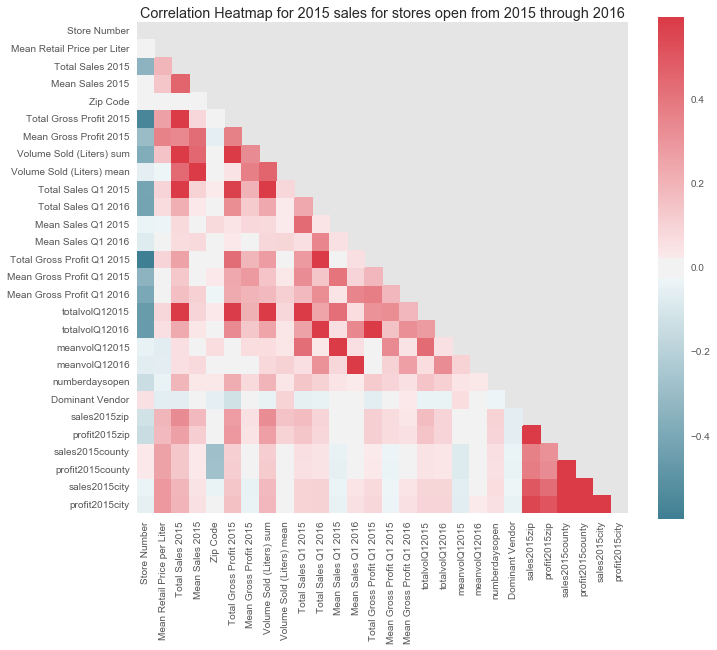

In [6]:
# Compute correlations for 2015 sales
plt.style.use('ggplot')
corr_sales = sales.corr()

#mask for upper triangle
mask = np.zeros_like(corr_sales, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_sales, mask=mask, cmap=cmap, vmax=.3,
            square=True, ax=ax)
plt.title('Correlation Heatmap for 2015 sales for stores open from 2015 through 2016')
'''I am seeing the expected correlations between sales and profits. Where it is weak is zip code, suggesting no correlation between zip code and sales.'''

'''Numbers of days open, mean retail price seem to be good continuous variables for regression. The rest look categorical.'''

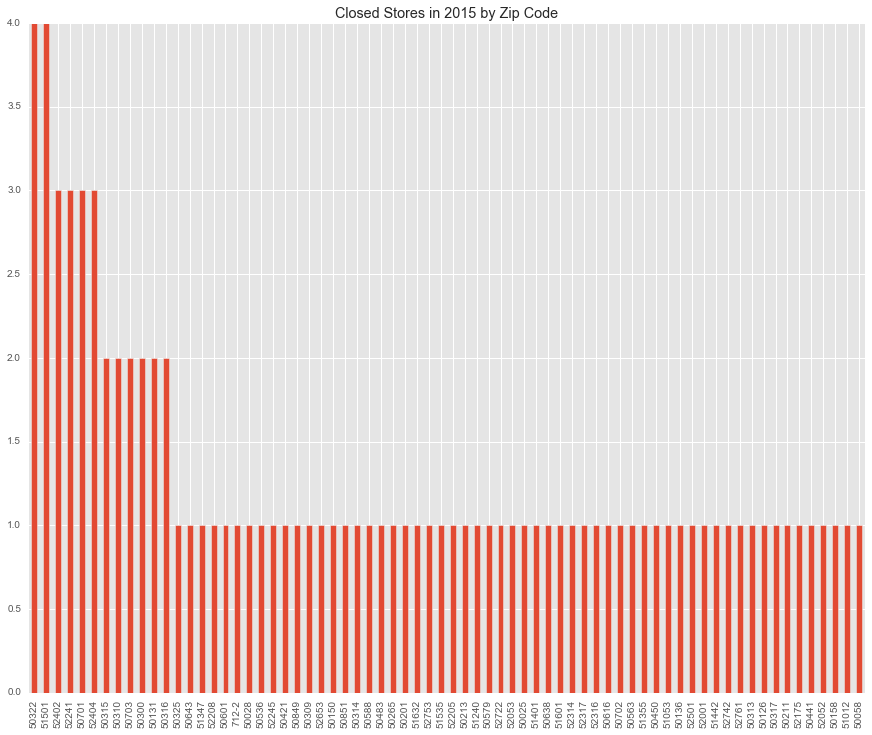

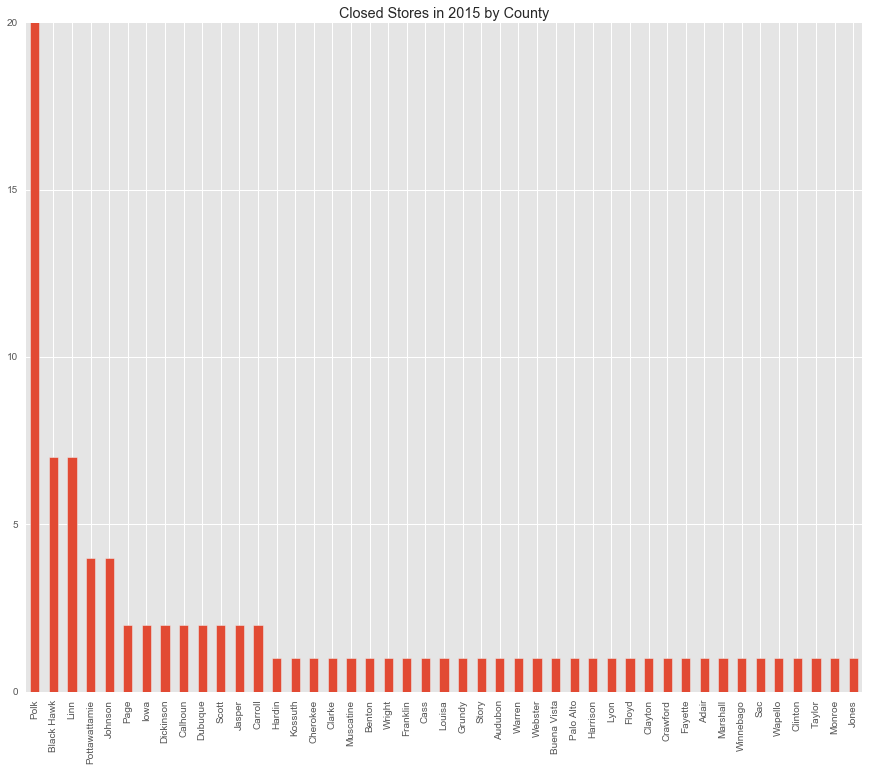

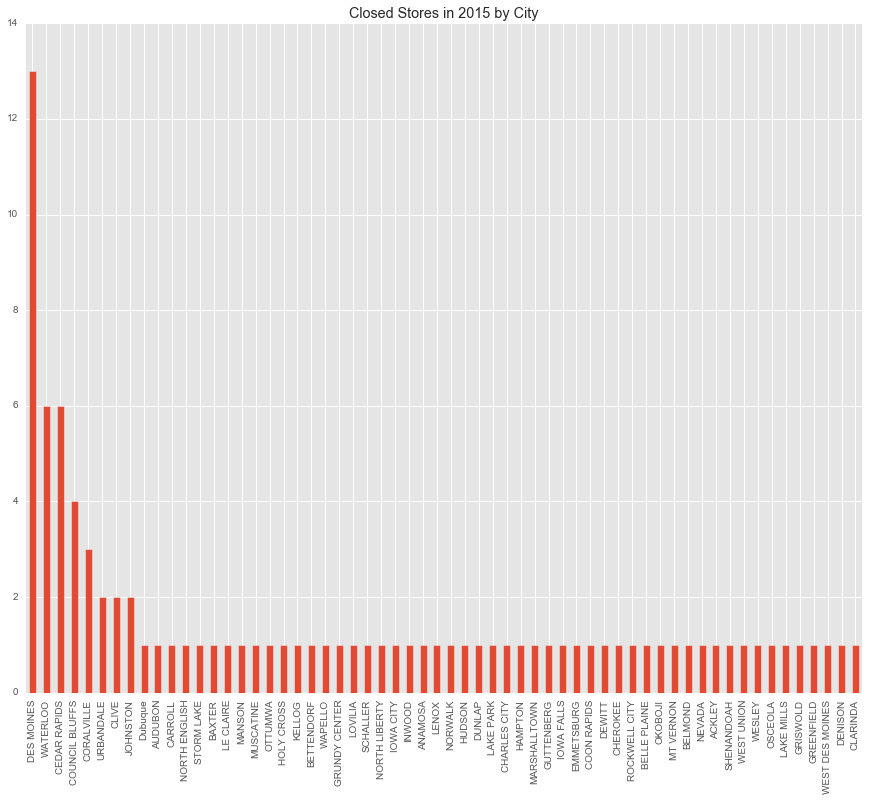

In [7]:
# Perform some exploratory analysis, make a few plots
#I want to chart the count of closed 2015 stores by county, zip, and city.

plt.style.use('ggplot')
plt.figure(1)
sales_2015_closed['Zip Code'].value_counts().plot(kind = 'bar', figsize=(15,12))
plt.title('Closed Stores in 2015 by Zip Code')

'''As can be seen, there are zip codes with a higher number of store closures, but without scale, not as meaningful.'''

plt.figure(2)
sales_2015_closed['County'].value_counts().plot(kind = 'bar', figsize=(15,12))
plt.title('Closed Stores in 2015 by County')

plt.figure(3)
sales_2015_closed['City'].value_counts().plot(kind = 'bar', figsize=(15,12))
plt.title('Closed Stores in 2015 by City')

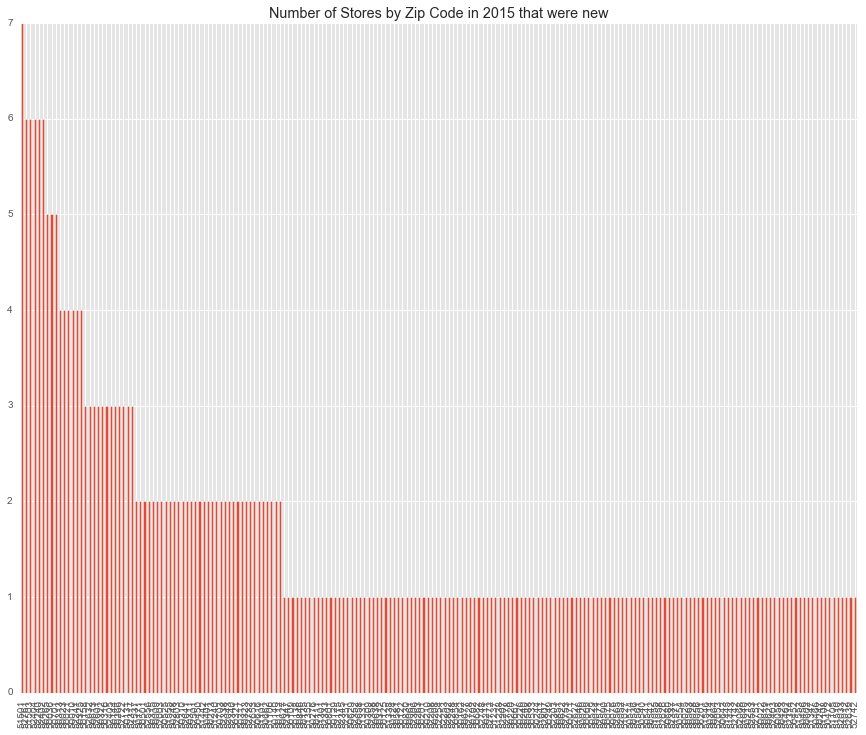

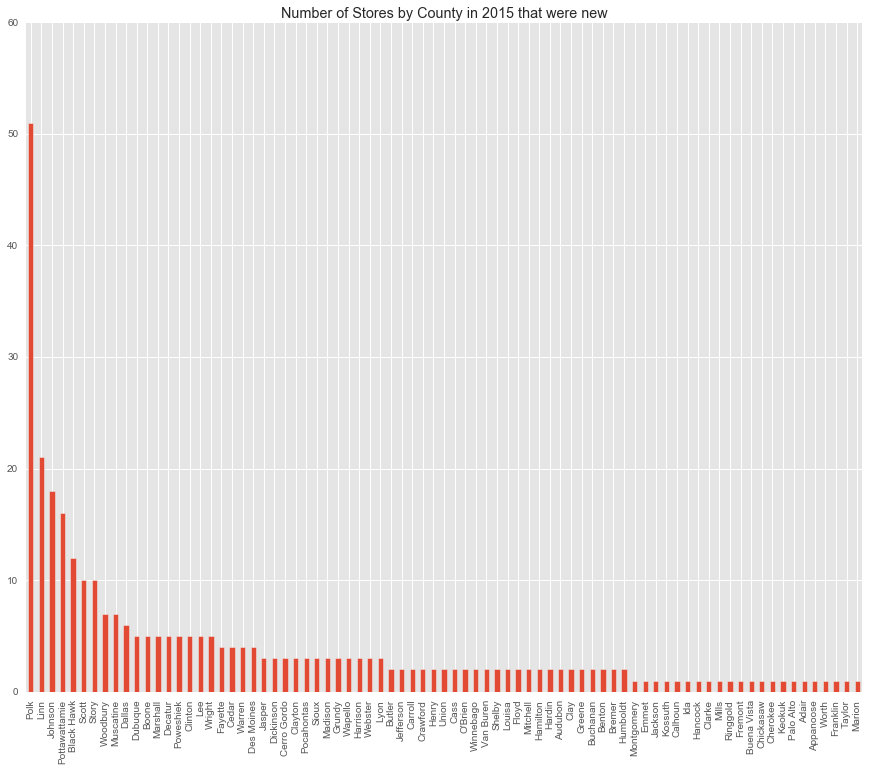

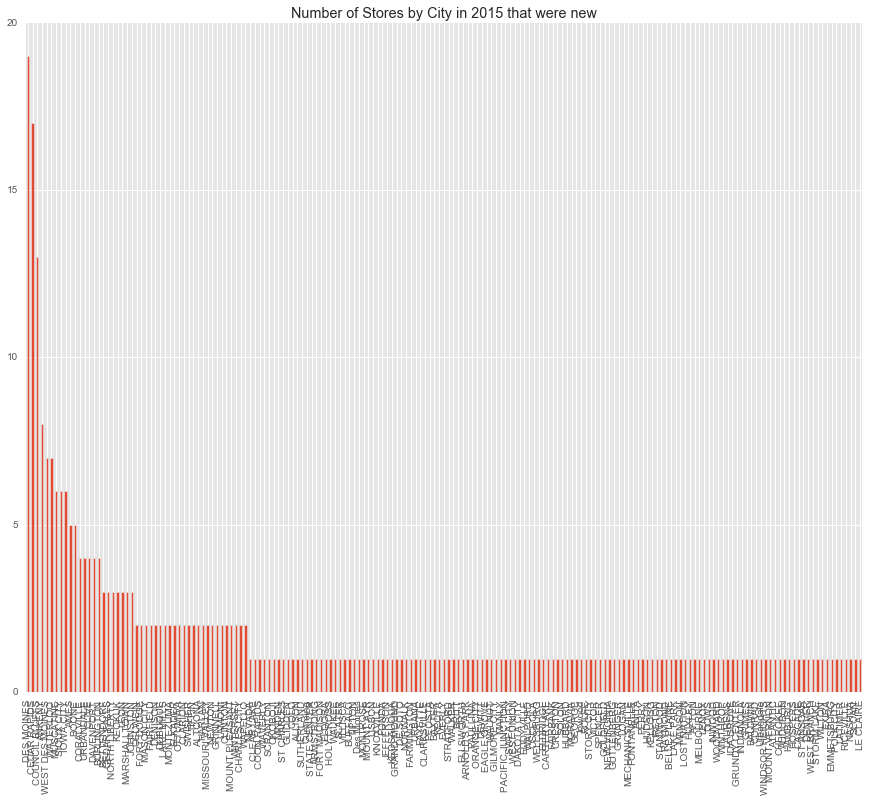

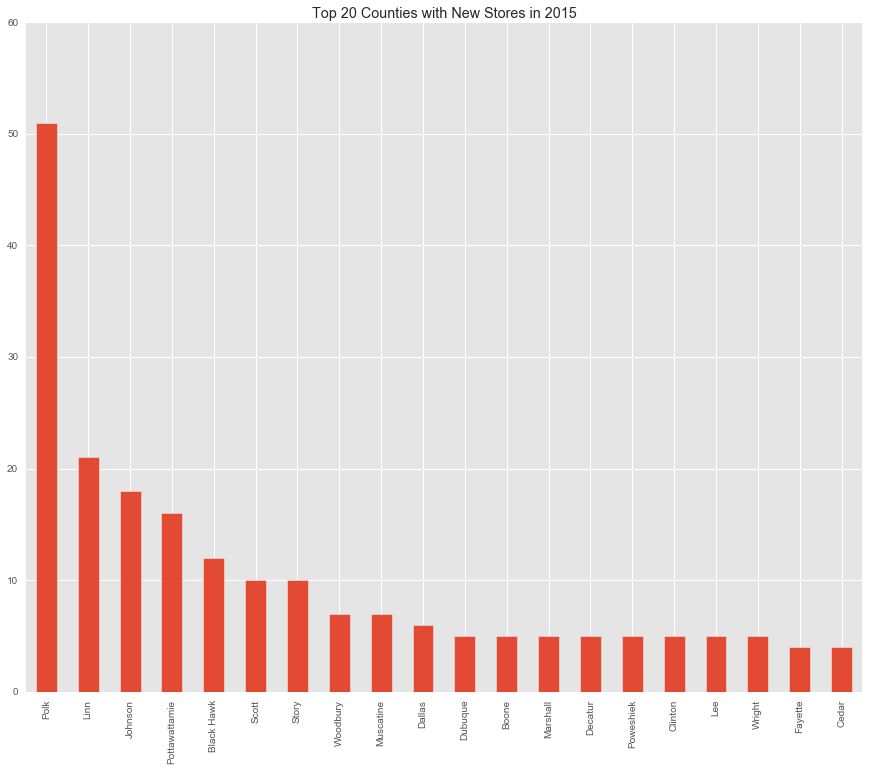

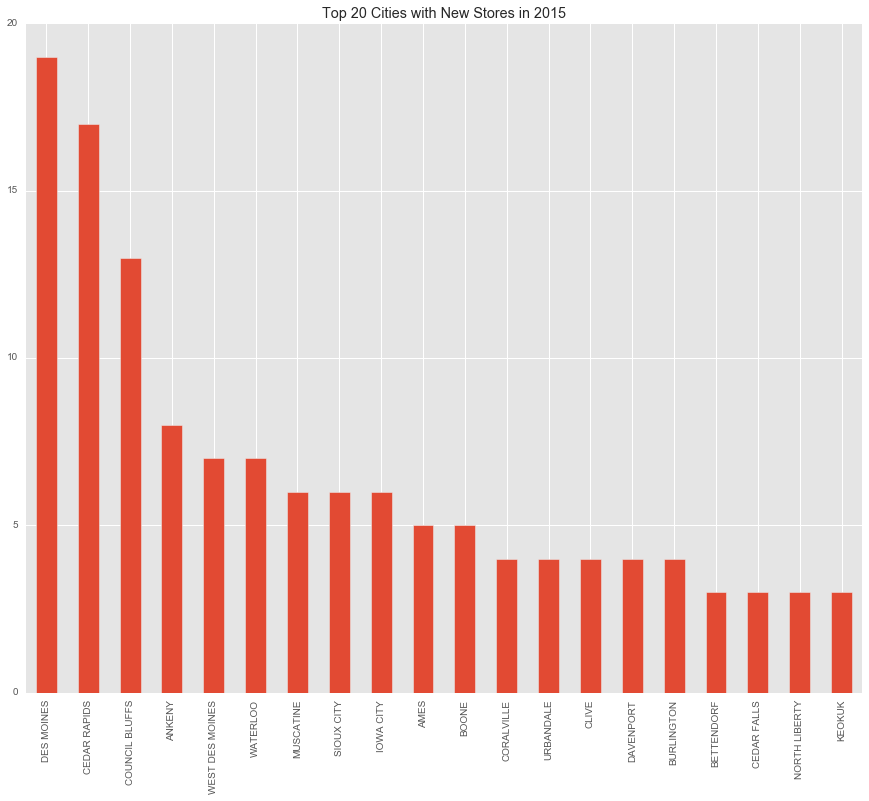

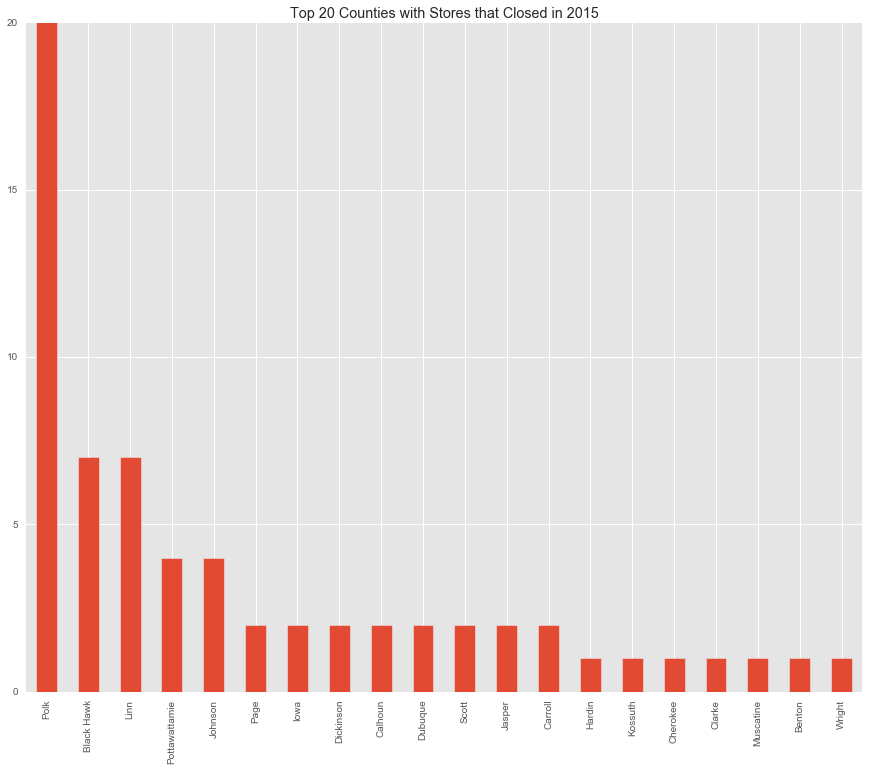

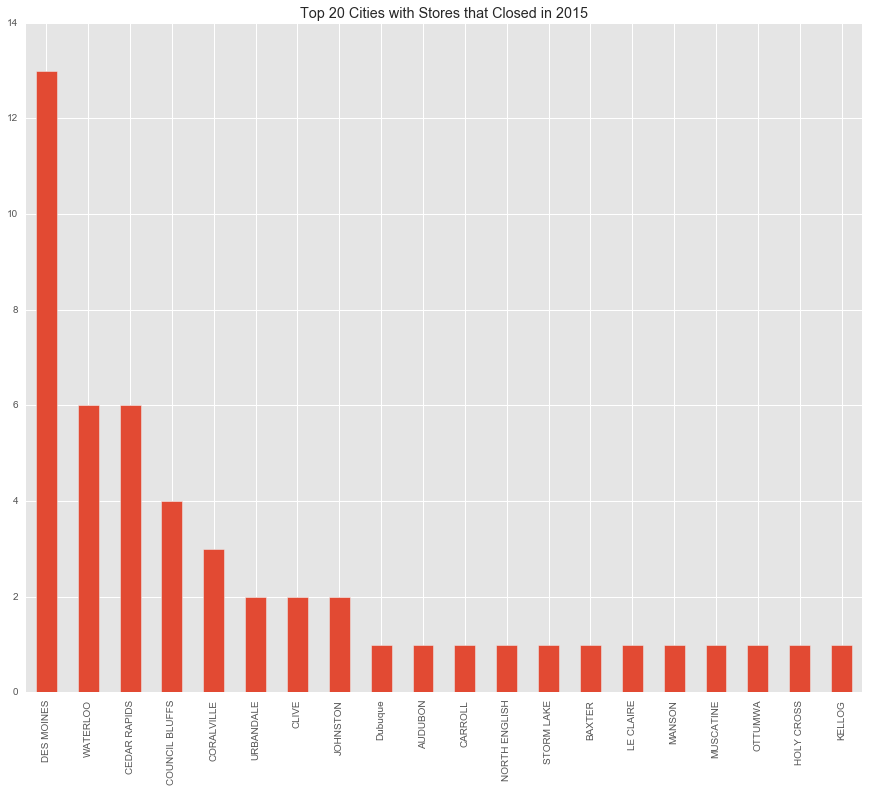

In [9]:
#I want to chart the count of new 2015 stores by county, zip, and city.

plt.figure(1)
sales_2015_new['Zip Code'].value_counts().plot(kind = 'bar', figsize = (15,12))
plt.title("Number of Stores by Zip Code in 2015 that were new")

plt.figure(2)
sales_2015_new['County'].value_counts().plot(kind = 'bar', figsize = (15,12))
plt.title("Number of Stores by County in 2015 that were new")

plt.figure(3)
sales_2015_new['City'].value_counts().plot(kind = 'bar', figsize = (15,12))
plt.title("Number of Stores by City in 2015 that were new")

plt.figure(4)
sales_2015_new['County'].value_counts()[:20].plot(kind = 'bar', figsize = (15,12))
plt.title("Top 20 Counties with New Stores in 2015")

plt.figure(5)
sales_2015_new['City'].value_counts()[:20].plot(kind = 'bar', figsize = (15,12))
plt.title("Top 20 Cities with New Stores in 2015")

plt.figure(6)
sales_2015_closed['County'].value_counts()[:20].plot(kind = 'bar', figsize = (15,12))
plt.title("Top 20 Counties with Stores that Closed in 2015")

plt.figure(7)
sales_2015_closed['City'].value_counts()[:20].plot(kind = 'bar', figsize = (15,12))
plt.title("Top 20 Cities with Stores that Closed in 2015")

#I want to chart its proportion to stores that were open for the whole timeperiod.

In [140]:
#Get the days open for closed and new stores.


sales_2015_closed.numberdaysopen = (sales_2015_closed['Last Date']- sales_2015_closed['First Date']).dt.days

sales_2015_new.numberdaysopen = (sales_2015_new['Last Date']- sales_2015_new['First Date']).dt.days

#Getting rid of zero mins
for i in range(len(sales_2015_closed.numberdaysopen)):
    if sales_2015_closed.numberdaysopen[i] == 0:
        sales_2015_closed.numberdaysopen[i] = 1
for i in range(len(sales_2015_new.numberdaysopen)):
    if sales_2015_new.numberdaysopen[i] == 0:
        sales_2015_new.numberdaysopen[i] = 1
        
#Average Sales per day per store.

sales_2015_closed['avgsalesperday'] = sales_2015_closed['Sale (Dollars) sum']/(sales_2015_closed.numberdaysopen)
sales_2015_new['avgsalesperday'] = sales_2015_new['Sale (Dollars) sum']/(sales_2015_new.numberdaysopen)
sales_2015_closed['avgprofitperday'] = sales_2015_closed['grossprofit sum']/(sales_2015_closed.numberdaysopen)
sales_2015_new['avgprofitperday'] = sales_2015_new['grossprofit sum']/sales_2015_new.numberdaysopen

sales['avgsalesperday'] =  sales['Total Sales 2015']/sales.numberdaysopen
sales['grossprofitperday'] = sales['Total Gross Profit 2015']/sales.numberdaysopen

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.


In [304]:
#Trying to get by the county the average sales per store. Thinking I want to sum the sales by county and divide by number of stores.
#Looks like the pivot already does this.
#Data for existing stores
existing_stores_avgsales_county = pd.pivot_table(sales, index = ['County'], values = ['totalsales2015', 'Mean Retail Price per Liter', 'Volume Sold (Liters) sum'], aggfunc = [np.mean])
existing_stores_avgsales_city = pd.pivot_table(sales, index = ['City'], values = ['totalsales2015', 'Mean Retail Price per Liter', 'Volume Sold (Liters) sum'], aggfunc = [np.mean])
existing_stores_avgsales_zip = pd.pivot_table(sales, index = ['Zip Code'], values = ['totalsales2015', 'Mean Retail Price per Liter', 'Volume Sold (Liters) sum'], aggfunc = [np.mean])


#Data for Closed Stores
closed_stores_avgsales_county = pd.pivot_table(sales_2015_closed, index = ['County'], values = ['Sale (Dollars) sum', 'retailpriceperliter mean', 'Volume Sold (Liters) sum'], aggfunc = [np.mean])
closed_stores_avgsales_city = pd.pivot_table(sales_2015_closed, index = ['City'], values = ['Sale (Dollars) sum', 'retailpriceperliter mean', 'Volume Sold (Liters) sum'], aggfunc = [np.mean])
closed_stores_avgsales_zip = pd.pivot_table(sales_2015_closed, index = ['Zip Code'], values = ['Sale (Dollars) sum', 'retailpriceperliter mean', 'Volume Sold (Liters) sum'], aggfunc = [np.mean])

#Data for New Stores
#Data for Closed Stores
new_stores_avgsales_county = pd.pivot_table(sales_2015_new, index = ['County'], values = ['Sale (Dollars) sum', 'retailpriceperliter mean', 'Volume Sold (Liters) sum'], aggfunc = [np.mean])
new_stores_avgsales_city = pd.pivot_table(sales_2015_new, index = ['City'], values = ['Sale (Dollars) sum', 'retailpriceperliter mean', 'Volume Sold (Liters) sum'], aggfunc = [np.mean])
new_stores_avgsales_zip = pd.pivot_table(sales_2015_new, index = ['Zip Code'], values = ['Sale (Dollars) sum', 'retailpriceperliter mean', 'Volume Sold (Liters) sum'], aggfunc = [np.mean])



In [303]:
existing_stores_avgsales_county

mean
              Volume Sold (Liters) sum
County                                
Adair                      5509.400000
Adams                      7547.620000
Allamakee                 12817.496000
Appanoose                 13082.707500
Benton                    16528.270000
Black Hawk                22202.974444
Boone                     14124.087778
Bremer                    20251.216667
Buchanan                  13177.928571
Buena Vista               15649.422500
Butler                     3978.066000
Calhoun                    6786.250000
Carroll                   27598.815000
Cass                      16099.800000
Cedar                      8452.157500
Cerro Gordo               32680.976154
Cherokee                  10425.235000
Chickasaw                  7002.000000
Clarke                    14053.350000
Clay                      30285.635000
Clayton                    6088.793333
Clinton                   31014.538571
Crawford                  27745.023333
Dallas                    32755.734444
Davis                      8001.000000
Delaware                  21493.720000
Des Moines                24259.159000
Dickinson                 34064.560000
Dubuque                   25017.088636
Emmet                     14749.200000
...                                ...
Muscatine                 18758.887273
O'Brien                   14070.521667
Osceola                   15276.170000
Page                      12447.060000
Palo Alto                  8103.230000
Plymouth                  16329.154286
Pocahontas                12458.325000
Polk                      29373.417295
Pottawattamie             24212.760833
Poweshiek                 11710.142857
Ringgold                   3732.420000
Sac                        8442.426000
Scott                     24230.674318
Shelby                    13555.850000
Sioux                     17276.375000
Story                     25282.288571
Tama                      12322.342500
Taylor                     4418.220000
Union                     17255.325000
Van Buren                  8366.420000
Wapello                   20353.824444
Warren                    15782.158889
Washington                15598.375000
Wayne                      6390.480000
Webster                   16582.418462
Winnebago                 16082.253333
Winneshiek                19533.608000
Woodbury                  23985.532727
Worth                      9988.700000
Wright                     8737.807500

[96 rows x 1 columns]

'Scaled by day, these data are meaningless for closed stores because some of the sales per day were infinite for some (meaning First and Last Date were same, meaning they were open for maybe one day. Probably a data cleaning issue to look for'

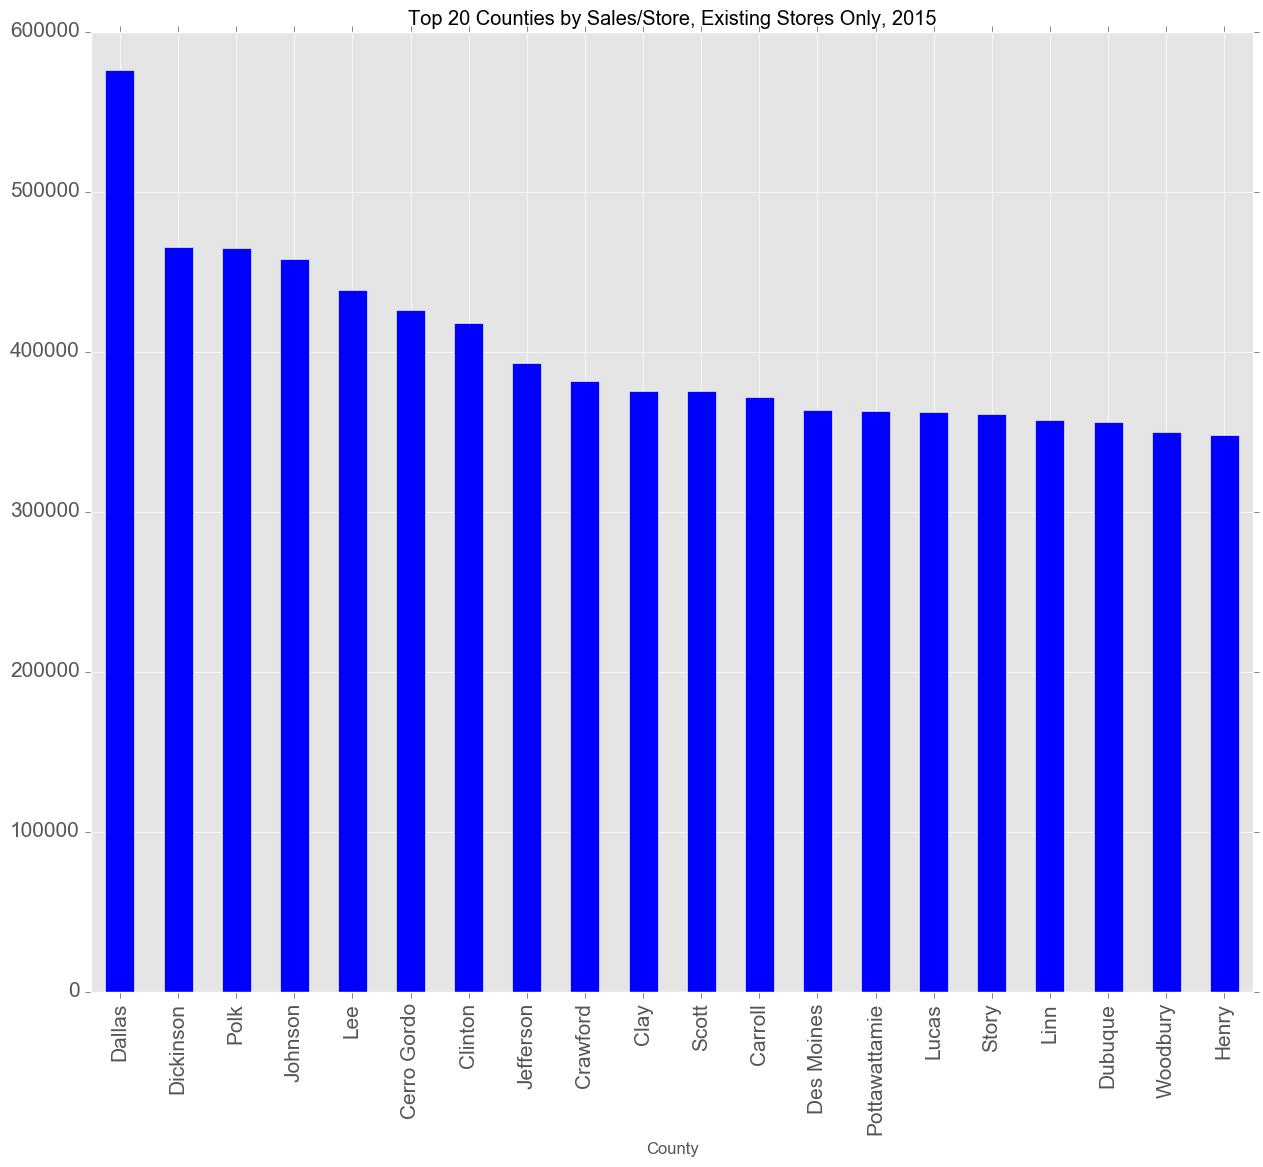

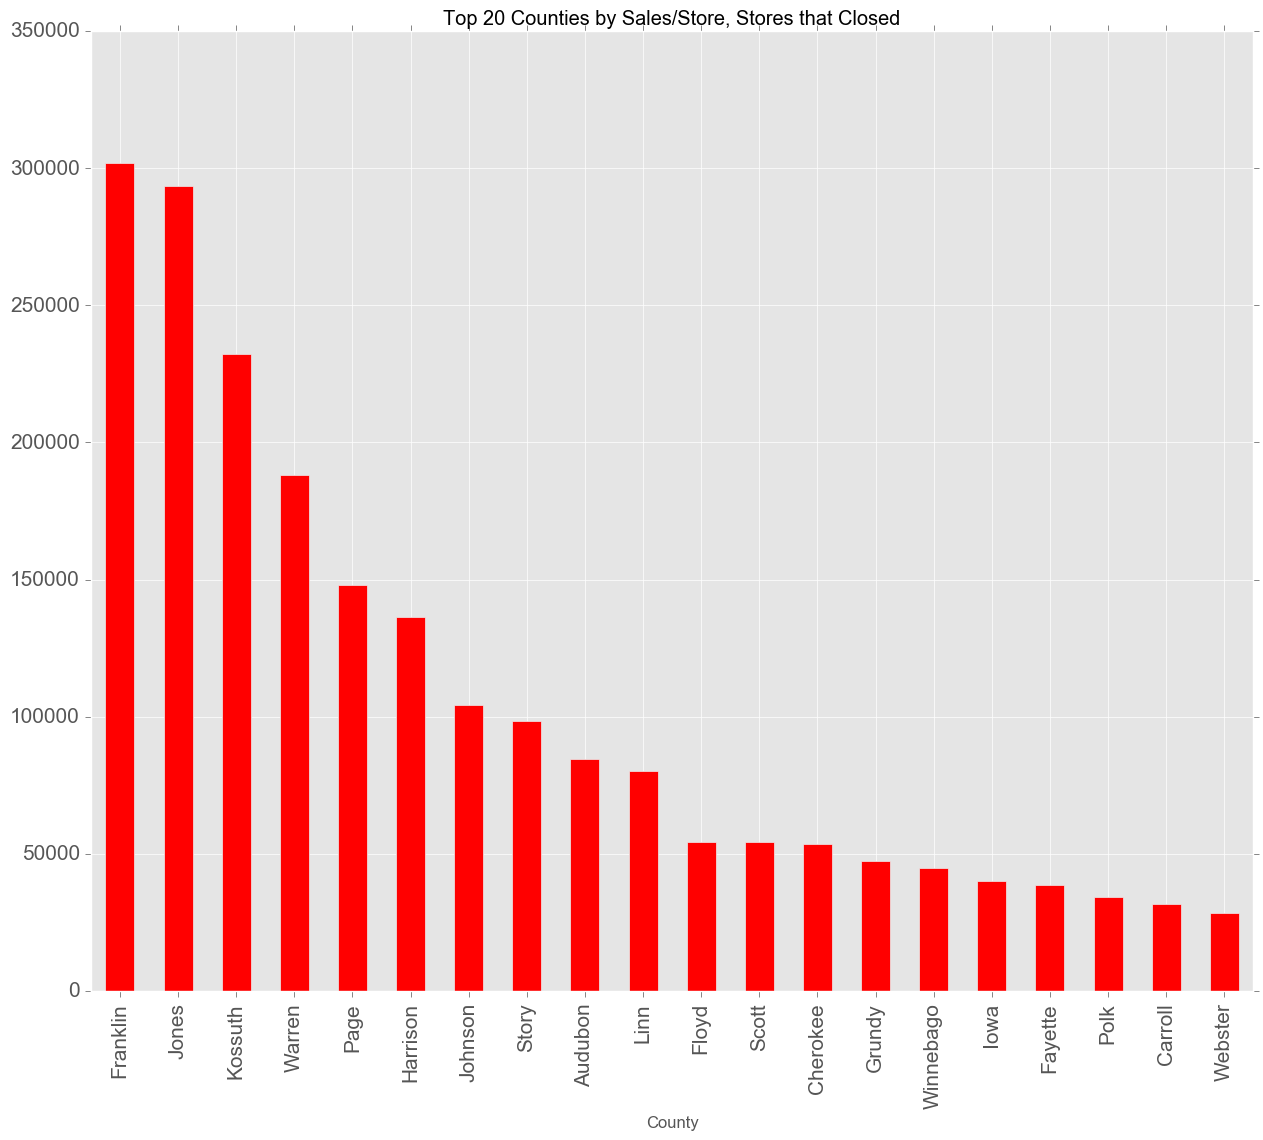

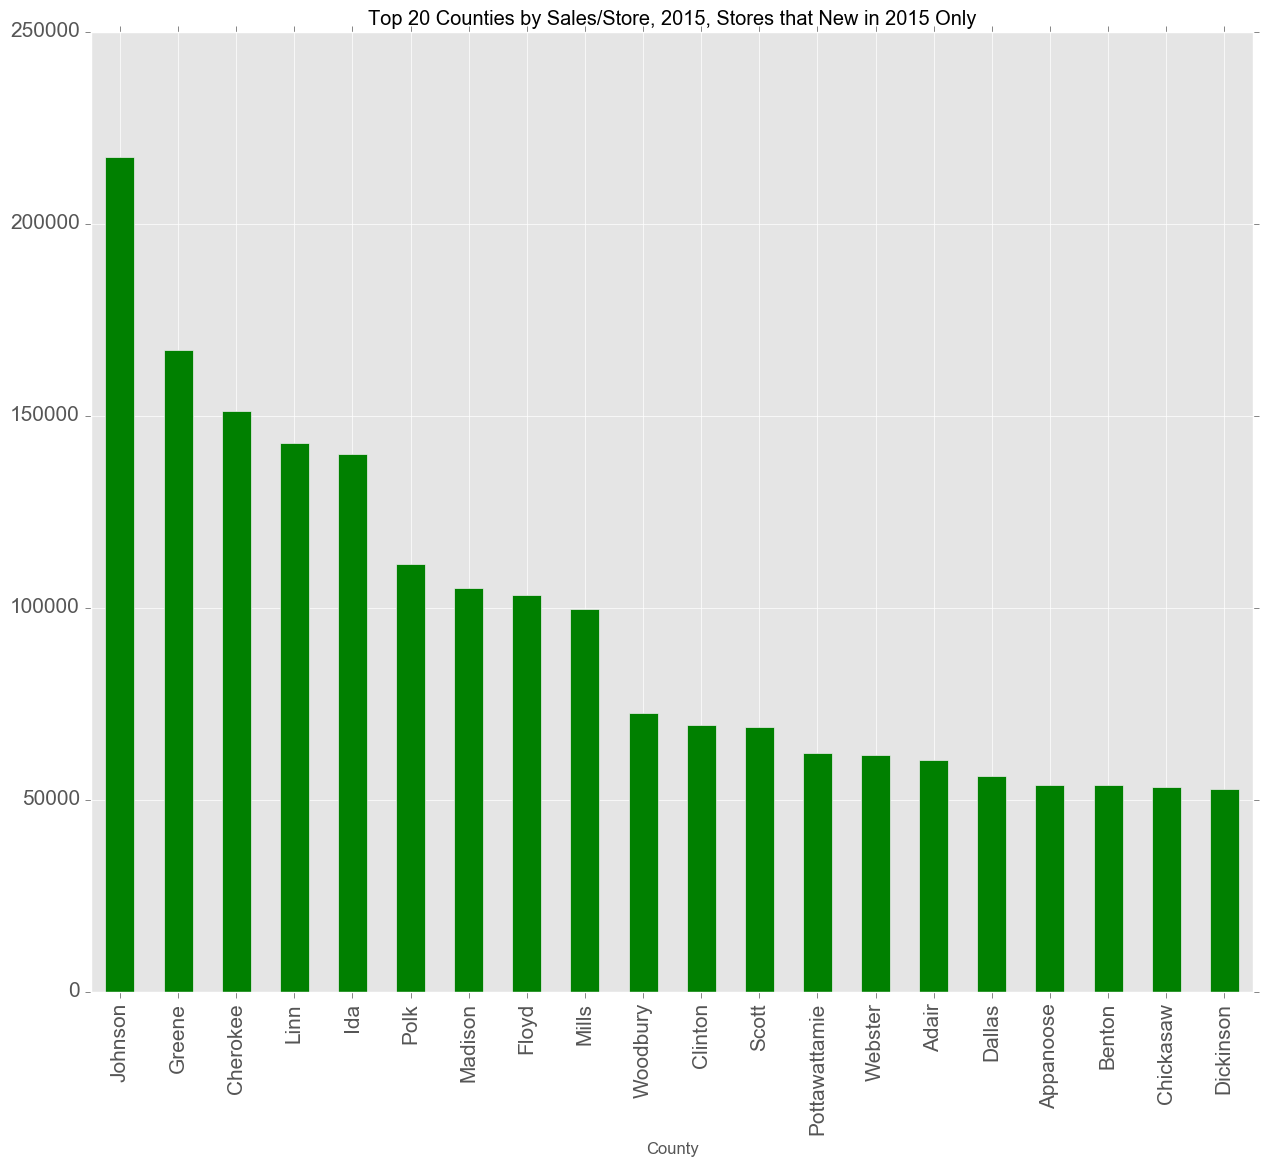

In [305]:
#Visualizing the sales per store average by county, top 20.

#print existing_stores_avgsales_county['mean']['Total Sales 2015'].sort_values(ascending = False)


plt.figure(1)
existing_stores_avgsales_county['mean']['totalsales2015'].sort_values(ascending = False)[:20].plot(kind = 'bar', color = 'b', figsize = (15,12), fontsize = 15)
plt.title("Top 20 Counties by Sales/Store, Existing Stores Only, 2015")

plt.figure(2)
closed_stores_avgsales_county['mean']['Sale (Dollars) sum'].sort_values(ascending = False)[:20].plot(kind = 'bar', color = 'r', figsize = (15,12), fontsize = 15)
plt.title("Top 20 Counties by Sales/Store, Stores that Closed")

plt.figure(3)
new_stores_avgsales_county['mean']['Sale (Dollars) sum'].sort_values(ascending = False)[:20].plot(kind = 'bar', color = 'g', figsize = (15,12), fontsize = 15)
plt.title("Top 20 Counties by Sales/Store, 2015, Stores that New in 2015 Only")

'''Scaled by day, these data are meaningless for closed stores because some of the sales per day were infinite for some (meaning First and Last Date were same, meaning they were open for maybe one day. Probably a data cleaning issue to look for'''
#Let's do the individual ones, then see if I can do a bar chart to see the avg sales by county from all datasets, orged by existing county index.
#Then correlations 

#Also note that sales = P*Q by definition. So a linear model of sales seems a bit silly.

#Besides, the store owner can control his average price, the category he focuses on, his location, and how many days he is open. He can not control his volume sold, directly.

#So a more interesting model might be predictors of volumes sold, and then checking for a price*volume what the max revenue is?


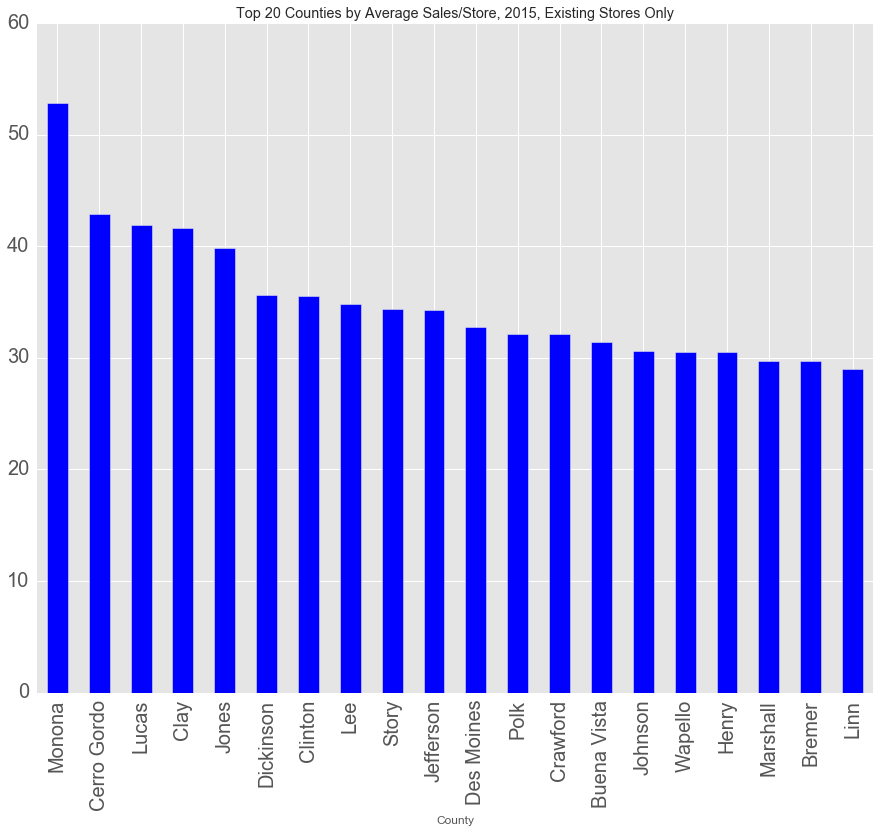

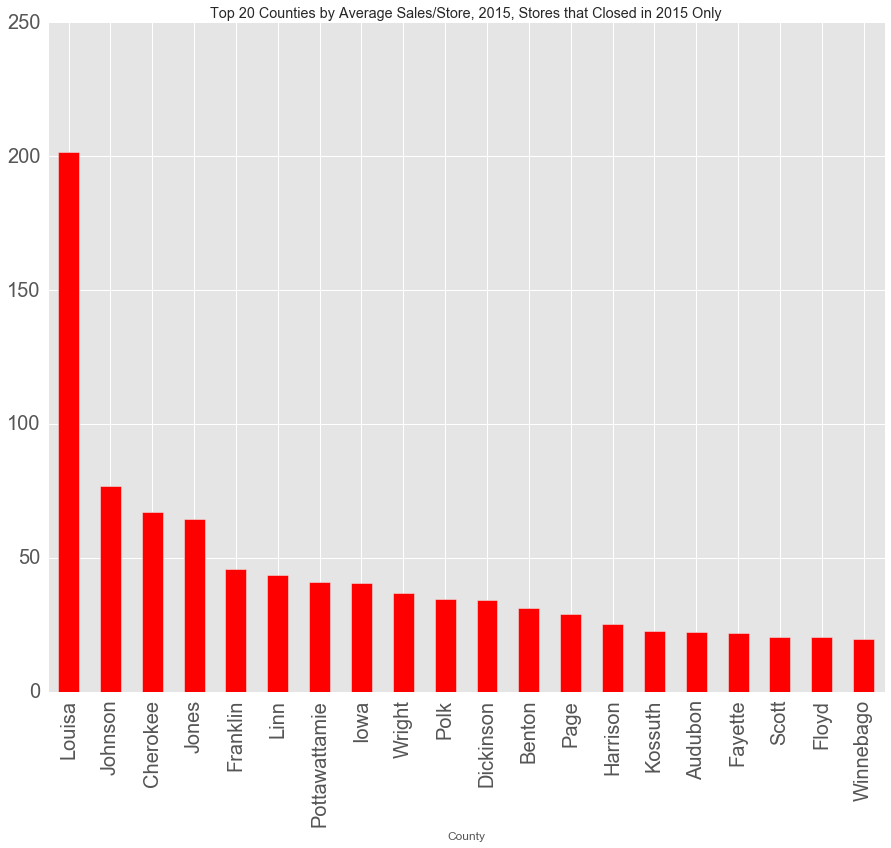

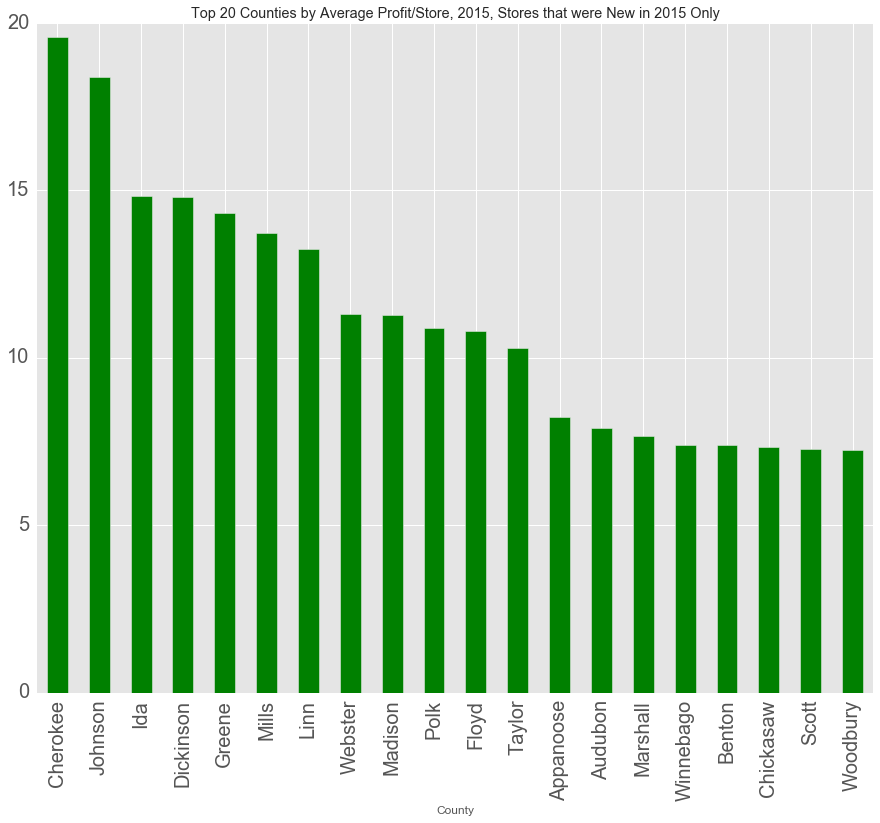

In [148]:
plt.figure(1)
existing_stores_avgsales_county['mean']['grossprofitperday'].sort_values(ascending = False)[:20].plot(kind = 'bar', color = 'b', figsize = (15,12), fontsize = 20)
plt.title("Top 20 Counties by Average Sales/Store, 2015, Existing Stores Only")

plt.figure(2)
closed_stores_avgsales_county['mean']['avgprofitperday'].sort_values(ascending = False)[:20].plot(kind = 'bar', color = 'r', figsize = (15,12), fontsize = 20)
plt.title("Top 20 Counties by Average Sales/Store, 2015, Stores that Closed in 2015 Only")

plt.figure(3)
new_stores_avgsales_county['mean']['avgprofitperday'].sort_values(ascending = False)[:20].plot(kind = 'bar', color = 'g', figsize = (15,12), fontsize = 20)
plt.title("Top 20 Counties by Average Profit/Store, 2015, Stores that were New in 2015 Only")



In [151]:
#The only continuous relationship I can think of would be retailpriceperliter compared to sales, since that could influence the amount of sales.
#other variables are categorical, even zip code. Though number of days open is also decent...

#I wonder if a model I predict could tell me the optimal price for sales? Probably.

#Some final data to visualize:

##Price to Volume
##Bar chart of price to category


Store Number                            int64
City                                   object
Mean Retail Price per Liter           float64
Total Sales 2015                      float64
Mean Sales 2015                       float64
Zip Code                                int64
County                                 object
Total Gross Profit 2015               float64
Mean Gross Profit 2015                float64
Volume Sold (Liters) sum              float64
Volume Sold (Liters) mean             float64
First Date                     datetime64[ns]
Last Date                      datetime64[ns]
Total Sales Q1 2015                   float64
Total Sales Q1 2016                   float64
Mean Sales Q1 2015                    float64
Mean Sales Q1 2016                    float64
Total Gross Profit Q1 2015            float64
Mean Gross Profit Q1 2015             float64
Mean Gross Profit Q1 2016             float64
totalvolQ12015                        float64
totalvolQ12016                    

In [229]:
#Getting rid of infinity from certain calcs.
sales.replace([np.inf, -np.inf], np.nan, inplace = True)
sales = sales.dropna(axis = 0, how = 'any')

In [234]:
#renaming two columns
sales.rename(columns = {'Mean Retail Price per Liter' : 'meanpriceliter', 'Category Most Sold' : 'category', 'Volume Sold (Liters) mean': 'meanvolume'}, inplace = True)
sales.rename(columns = {'Total Sales 2015': 'totalsales2015', 'Total Sales Q1 2015': 'salesq115', 'Total Sales Q1 2016': 'salesq116'}, inplace = True)

SpearmanrResult(correlation=-0.34258500718012624, pvalue=2.9543591401207021e-23)


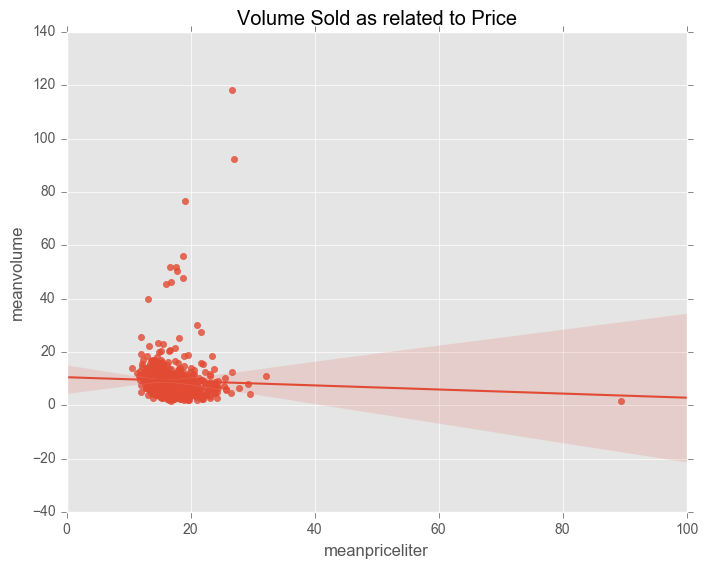

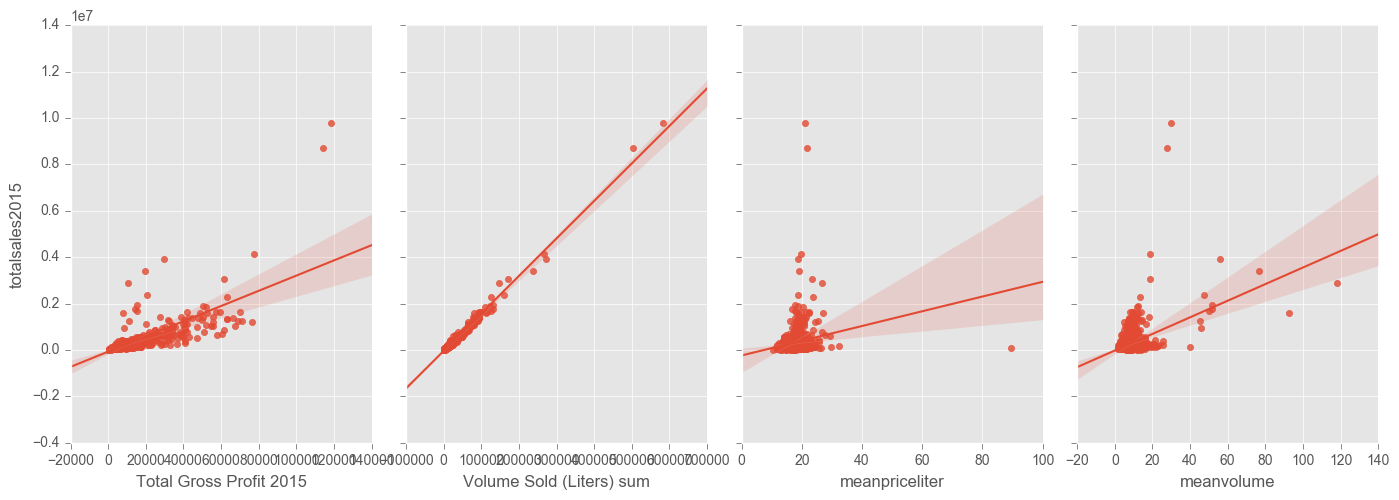

In [237]:
#Price to Volume
plt.style.use('ggplot')
plt.figure(1)
sns.regplot(x = 'meanpriceliter', y = 'meanvolume', data = sales)
plt.title("Volume Sold as related to Price")


import scipy.stats as stats
print stats.spearmanr(sales['meanpriceliter'], sales['meanvolume'])

'''As the price increases, volume decreases. Expected.'''

'''Note the outliers here on the volume side - probably cheap liquor. The outlier on the right side of price is either expensive whisky by the barrel or cognac.'''

#pairplot
sns.pairplot(sales, x_vars=['Total Gross Profit 2015','Volume Sold (Liters) sum', 'meanpriceliter', 'meanvolume'], y_vars='totalsales2015', size=5, aspect=0.7, kind='reg')

In [240]:
#outliers removed from volume and price. Volume above 60, price above 60.

sales_reduced = sales[np.abs(sales.meanvolume-sales.meanvolume.mean())<=(3*sales.meanvolume.std())]
sales_clean = sales_reduced[np.abs(sales_reduced.meanpriceliter-sales_reduced.meanpriceliter.mean())<=(3*sales_reduced.meanpriceliter.std())]

SpearmanrResult(correlation=-0.36533972612789634, pvalue=5.6240983513145721e-26)


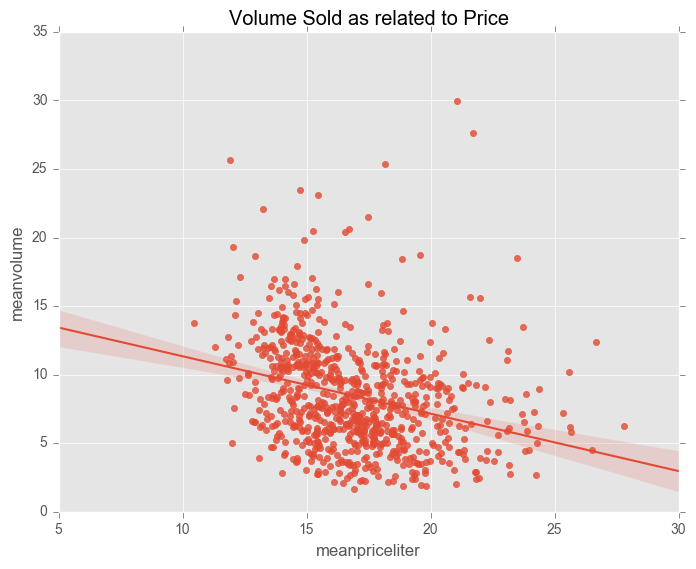

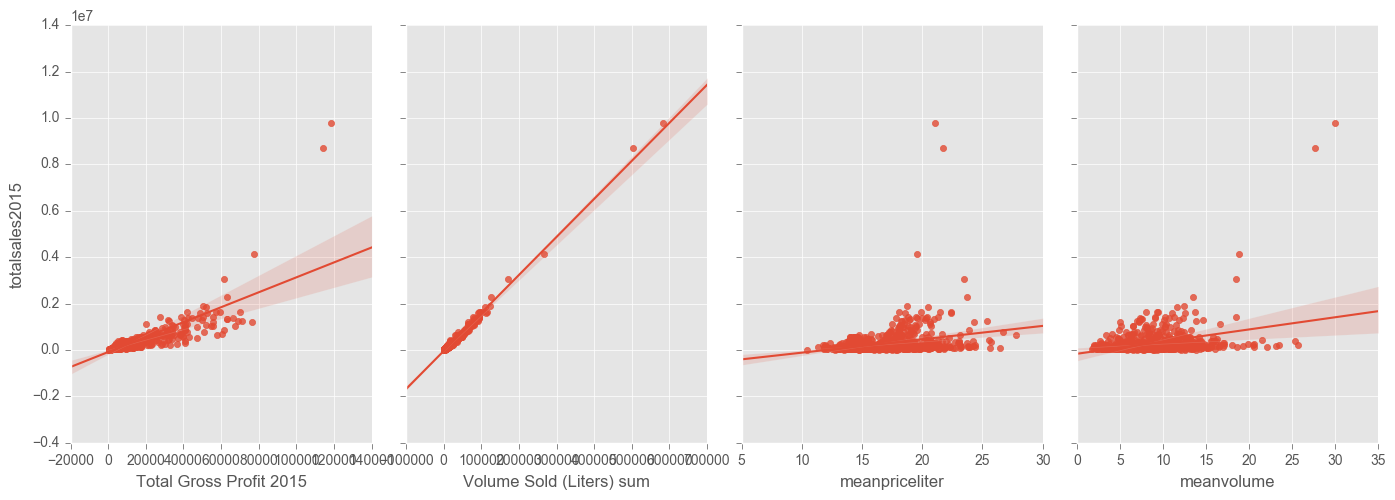

In [247]:
#New pairplots after outliers gone.
#Price to Volume
plt.style.use('ggplot')
plt.figure(1)
sns.regplot(x = 'meanpriceliter', y = 'meanvolume', data = sales_clean)
plt.title("Volume Sold as related to Price")


import scipy.stats as stats
print stats.spearmanr(sales_clean['meanpriceliter'], sales_clean['meanvolume'])

'''As the price increases, volume decreases. Expected.'''

'''Note the outliers here on the volume side - probably cheap liquor. The outlier on the right side of price is either expensive whisky by the barrel or cognac.'''

#pairplot
sns.pairplot(sales_clean, x_vars=['Total Gross Profit 2015','Volume Sold (Liters) sum', 'meanpriceliter', 'meanvolume'], y_vars='totalsales2015', size=5, aspect=0.7, kind='reg')

In [241]:
#Group by category most sold.

category_price = sales_clean.groupby('category')['meanpriceliter'].mean()
category_price

category
AMERICAN GRAPE BRANDIES      21.364147
BLENDED WHISKIES             17.165514
CANADIAN WHISKIES            16.482608
IMPORTED GRAPE BRANDIES      24.196074
IMPORTED VODKA               23.757989
IMPORTED VODKA - MISC        21.720597
STRAIGHT BOURBON WHISKIES    22.649944
TEQUILA                      21.980795
VODKA 80 PROOF               16.749309
VODKA FLAVORED               18.461889
WHISKEY LIQUEUR              16.924621
Name: meanpriceliter, dtype: float64

In [182]:
sales_Q115_final = pd.read_csv("sales_Q12015_filtered.csv")
sales_Q116_final = pd.read_csv("sales_Q12016_filtered.csv")

In [184]:
sales_Q115_final.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [185]:
sales_Q116_final.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [189]:
sales_Q115_final['First Date'] = pd.to_datetime(sales_Q115_final['First Date'], infer_datetime_format = True)
sales_Q115_final['Last Date'] = pd.to_datetime(sales_Q115_final['Last Date'], infer_datetime_format = True)
sales_Q116_final['First Date'] = pd.to_datetime(sales_Q116_final['First Date'], infer_datetime_format = True)
sales_Q116_final['Last Date'] = pd.to_datetime(sales_Q116_final['Last Date'], infer_datetime_format = True)
sales_Q115_final.numberdaysopen = (sales_Q115_final['Last Date']- sales_Q115_final['First Date']).dt.days

sales_Q116_final.numberdaysopen = (sales_Q116_final['Last Date']- sales_Q116_final['First Date']).dt.days


In [230]:
sales.meanpriceliter.describe()

count    793.000000
mean      17.061475
std        3.857342
min       10.457300
25%       14.900649
50%       16.675058
75%       18.502723
max       89.400235
Name: meanpriceliter, dtype: float64

In [254]:

# Fit a linear model - I am just going to look at the 2015 total sales as my y.

from sklearn import linear_model
import statsmodels.formula.api
#features I plan to test on:
modeldata_cols = ['meanpriceliter', 'category', 'County']
smf_cols = ['meanpriceliter', 'category', 'County', 'totalsales2015']
modeldata = sales_clean[modeldata_cols]
category = pd.get_dummies(sales_clean['category'])
county = pd.get_dummies(sales_clean['County'])
modeldata2 = modeldata.join(category)
modeldata3 = modeldata2.join(county)
modeldata3.drop(['category'], axis = 1, inplace = True)
modeldata3.drop(['County'], axis = 1, inplace = True)
smf_data = sales_clean[smf_cols].join(category).join(county)

#lm = linear_model.LinearRegression()

#model = lm.fit(modeldata3, sales_clean.totalsales2015)
#model
'''This is a poor first model. What we see is that county is nearly meaningless as a predictor of sales. Also, the intercept makes no sense. Negative sales is unreasonable.'''

model_smf = smf.ols(formula = "totalsales2015 ~ meanpriceliter + C(County) + C(category)", data = sales_clean).fit()
model_smf.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         totalsales2015   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     5.826
Date:                Fri, 06 May 2016   Prob (F-statistic):           3.30e-47
Time:                        01:02:26   Log-Likelihood:                -11178.
No. Observations:                 778   AIC:                         2.257e+04
Df Residuals:                     671   BIC:                         2.307e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------------
Intercept                                -9.413e+05   3.02e+05     -3.117      0.002     -1.53e+06 -3.48e+05
C(County)[T.Adams]                       -4.349e+04   4.97e+05     -0.088      0.930     -1.02e+06  9.32e+05
C(County)[T.Allamakee]                    1.219e+05   2.86e+05      0.426      0.670      -4.4e+05  6.84e+05
C(County)[T.Appanoose]                    1.216e+05   3.04e+05      0.401      0.689     -4.74e+05  7.18e+05
C(County)[T.Benton]                       1.755e+05   3.31e+05      0.531      0.596     -4.74e+05  8.25e+05
C(County)[T.Black Hawk]                   1.599e+05   2.17e+05      0.735      0.462     -2.67e+05  5.87e+05
C(County)[T.Boone]                       -2.379e+05   2.54e+05     -0.938      0.349     -7.36e+05   2.6e+05
C(County)[T.Bremer]                       2.273e+05   2.74e+05      0.829      0.408     -3.11e+05  7.66e+05
C(County)[T.Buchanan]                      4.31e+04   2.66e+05      0.162      0.871     -4.79e+05  5.66e+05
C(County)[T.Buena Vista]                  3.017e+04   2.59e+05      0.117      0.907     -4.78e+05  5.38e+05
C(County)[T.Butler]                       8.533e+04   2.87e+05      0.297      0.767     -4.79e+05   6.5e+05
C(County)[T.Calhoun]                      1.524e+05   3.32e+05      0.459      0.646     -4.99e+05  8.03e+05
C(County)[T.Carroll]                      3.511e+05   2.74e+05      1.281      0.201     -1.87e+05  8.89e+05
C(County)[T.Cass]                         1.511e+05   2.86e+05      0.528      0.598     -4.11e+05  7.13e+05
C(County)[T.Cedar]                        2.821e+04   3.04e+05      0.093      0.926     -5.68e+05  6.24e+05
C(County)[T.Cerro Gordo]                  3.222e+05   2.38e+05      1.351      0.177     -1.46e+05   7.9e+05
C(County)[T.Cherokee]                     8.652e+04   3.04e+05      0.285      0.776      -5.1e+05  6.83e+05
C(County)[T.Chickasaw]                    1.173e+05   3.31e+05      0.354      0.723     -5.33e+05  7.68e+05
C(County)[T.Clarke]                       1.192e+05   3.31e+05      0.361      0.719      -5.3e+05  7.69e+05
C(County)[T.Clay]                         3.313e+05   3.04e+05      1.091      0.276     -2.65e+05  9.27e+05
C(County)[T.Clayton]                       8.18e+04   2.75e+05      0.298      0.766     -4.57e+05  6.21e+05
C(County)[T.Clinton]                      3.051e+05   2.66e+05      1.148      0.251     -2.17e+05  8.27e+05
C(County)[T.Crawford]                     2.892e+05   3.31e+05      0.875      0.382      -3.6e+05  9.39e+05
C(County)[T.Dallas]                        1.61e+05   2.58e+05      0.623      0.534     -3.47e+05  6.69e+05
C(County)[T.Davis]                        7.442e+04   4.96e+05      0.150      0.881        -9e+05  1.05e+06
C(County)[T.Delaware]          

In [262]:
smf_data.dtypes
smf_data.rename(columns = {'IMPORTED VODKA - MISC': 'importedvodkamisc', 'VODKA 80 PROOF': 'vodka80', 'VODKA FLAVORED': 'vodkaflavored'}, inplace = True)

In [266]:
#second model
model_smf2 = smf.ols(formula = "totalsales2015 ~ meanpriceliter + C(category)", data = sales_clean).fit()
print model_smf2.summary()

#third model - explicitly modelling on the dummies that were relevant...
model_smf3 = smf.ols(formula = "totalsales2015 ~ meanpriceliter + TEQUILA + importedvodkamisc + vodka80 + vodkaflavored", data = smf_data).fit()
print model_smf3.summary()       
# Plot the data and the best fit line

# Compute the model fit
print ""
print 'The model fit is 0.454, but the model makes no sense. Volume is highly correlated to Sales, and price is negatively correlated to sales. Yet in this model, price increases lead to sales increases. And vodka and tequila are the best selling categories. The regression is counterintuitive, and quite frankly, probably not useful in predictive power. To tell a store owner to open in any county, focus on vodka and tequila, and that your consumers are price insensitive is what this model boils down to, which seems odd.'

                            OLS Regression Results                            
Dep. Variable:         totalsales2015   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     59.02
Date:                Fri, 06 May 2016   Prob (F-statistic):           1.99e-94
Time:                        01:12:48   Log-Likelihood:                -11193.
No. Observations:                 778   AIC:                         2.241e+04
Df Residuals:                     766   BIC:                         2.247e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

In [ ]:
# Predict Total 2016 sales, compare to 2015



In [271]:
# Try per zip code or city to get better resolution

#Let's see this quickly in statsmodels. If County didn't work, I doubt City or Zip will.

modeldata_cols = ['meanpriceliter', 'category', 'City', 'Zip Code']
smf_cols = ['meanpriceliter', 'category', 'City', 'Zip Code', 'totalsales2015']
modeldata = sales_clean[modeldata_cols]
category = pd.get_dummies(sales_clean['category'])
city = pd.get_dummies(sales_clean['City'])
zipcode = pd.get_dummies(sales_clean['Zip Code'])
modeldata2 = modeldata.join(category)
modeldata3 = modeldata2.join(city).join(zipcode)
modeldata3.drop(['category'], axis = 1, inplace = True)
modeldata3.drop(['City'], axis = 1, inplace = True)
modeldata3.drop(['Zip Code'], axis = 1, inplace = True)

smf_data_city = sales_clean[smf_cols].join(category).join(city).join(zipcode)

model_city_smf = smf.ols(formula = "totalsales2015 ~ meanpriceliter + C(City) + C(category)", data = smf_data_city).fit()
print model_city_smf.summary()

'''City does not add resolution'''

                            OLS Regression Results                            
Dep. Variable:         totalsales2015   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     1.980
Date:                Fri, 06 May 2016   Prob (F-statistic):           2.51e-11
Time:                        01:21:02   Log-Likelihood:                -11156.
No. Observations:                 778   AIC:                         2.285e+04
Df Residuals:                     511   BIC:                         2.409e+04
Df Model:                         266                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

'City does not add resolution'

In [ ]:
# Filter out stores that opened or closed throughout the year
# If this wasn't done already
#Already done.

In [284]:
#Fit Volume
smf_cols = ['meanpriceliter', 'category', 'City', 'Zip Code', 'totalsales2015', 'meanvolume']
category = pd.get_dummies(sales_clean['category'])
city = pd.get_dummies(sales_clean['City'])
zipcode = pd.get_dummies(sales_clean['Zip Code'])
smf_data_vol = sales_clean[smf_cols].join(category).join(city).join(zipcode)
smf_data_vol.replace('Zip Code', 'zipcode', inplace = True)

smf_model_vol = smf.ols(formula = "meanvolume ~ meanpriceliter + C(category)", data = smf_data_vol).fit()
print smf_model_vol.summary()

'''Since sales = price * volume, this is a more relevant model. While you would not want to recommend reducing price to zero, you could use the coefficients here to recommend which categories to emphasize for volume, or in short, what are the steady sellers (which look like cheap, everyday liquor).'''

                            OLS Regression Results                            
Dep. Variable:             meanvolume   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     18.53
Date:                Fri, 06 May 2016   Prob (F-statistic):           4.44e-33
Time:                        01:40:12   Log-Likelihood:                -2078.2
No. Observations:                 778   AIC:                             4180.
Df Residuals:                     766   BIC:                             4236.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------

'Since sales = price * volume, this is a more relevant model. While you would not want to recommend reducing price to zero, you could use the coefficients here to recommend which categories to emphasize for volume, or in short, what are the steady sellers (which look like cheap, everyday liquor).'

In [339]:
#2015 Q1 Sales model for testing on 2016.

sales_Q115_final.rename(columns = {'Sale (Dollars) sum' : 'q1sales', 'retailpriceperliter mean' : 'meanpriceliter', 'Volume Sold (Liters) sum': 'volumesold'}, inplace = True)
sales_Q116_final.rename(columns = {'Sale (Dollars) sum' : 'q1sales', 'retailpriceperliter mean' : 'meanpriceliter', 'Volume Sold (Liters) sum': 'volumesold'}, inplace = True)

model = smf.ols(formula = "q1sales ~ meanpriceliter", data = sales_Q115_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                q1sales   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     45.47
Date:                Fri, 06 May 2016   Prob (F-statistic):           2.98e-11
Time:                        02:40:15   Log-Likelihood:                -10437.
No. Observations:                 794   AIC:                         2.088e+04
Df Residuals:                     792   BIC:                         2.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept      -1.067e+05   2.52e+04     -4.228      0.000     -1.56e+05 -5.72e+04
meanpriceliter  9976.0445   1479.367      6.743      0.000      7072.101  1.29e+04
==============================================================================
Omnibus:                     1266.978   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           690292.505
Skew:                           9.428   Prob(JB):                         0.00
Kurtosis:                     146.212   Cond. No.                         98.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [349]:
#Use the model to predict Q1 2016.
import statsmodels.api as sm
sales_Q116_final.dtypes
X_pred = sales_Q116_final['meanpriceliter']
X_pred = sm.add_constant(X_pred)
ypred = model.predict(X_pred)
#X_pred

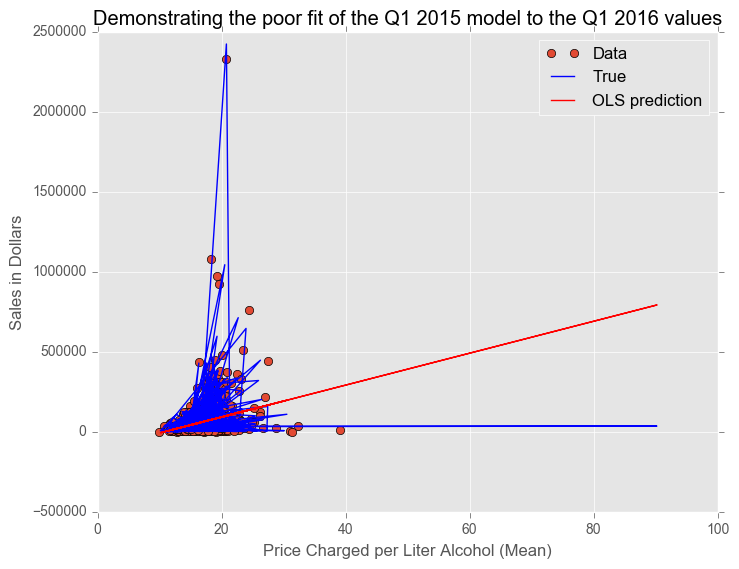

In [351]:
#Let's plot this.


fig, ax = plt.subplots()
ax.plot(sales_Q115_final.meanpriceliter, sales_Q115_final.q1sales, 'o', label="Data")
ax.plot(sales_Q116_final.meanpriceliter, sales_Q116_final.q1sales, 'b-', label="True")
ax.plot(sales_Q116_final.meanpriceliter, ypred, 'r', label="OLS prediction")
ax.legend(loc="best")
plt.title("Demonstrating the poor fit of the Q1 2015 model to the Q1 2016 values")
plt.xlabel("Price Charged per Liter Alcohol (Mean)")
plt.ylabel("Sales in Dollars");